Plot map of Twb mean + heatwave locations (Fig. 1b)

In [1]:
import sys
import os
import argparse
import numpy as np
import numpy.ma as ma
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

from matplotlib.patches import Rectangle, Patch
from matplotlib.colors import BoundaryNorm
from global_land_mask import globe

from config import CP4FIGDIR, CP4topofile
from CP4.make_climato.compute_daily_climato_var import load_var_daily_climato
from CP4.make_composites.a1_make_var_field import load_composite_dates_hhee, load_composite_coords_hhee
from CP4.plots.p_config import *

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [26]:
ds='CP4A'
res=4
var='twb'
window=6
y0=1997
y1=2006
months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
q_thresh=0.95
t_thresh=26.
min_hw_size=100.  # km2
max_hw_size=1000000.  # km2
sw=[0.25, 0.25]
tw=[-72, 72]
samtime=[12, 12]
n_days=3
meth='cc3d'
cnty=26
lat_range=[-35., 37.5]
lon_range=[-20., 52.]
regs=['WSahel', 'ESahel', 'CSahel', 'Guinea', 'CAfr', 'EAfr', 'Mozambique', 'WCoast', 'Nile', 'Suud', 'Djib', 'Tchad', 'SierraL', 'Horn']
regs2plot = ['Sahel', 'Guinea', 'CAfr']
flabel='b'

In [22]:
years = np.arange(y0, y1+1, 1)
years_ = str(y0) + '-' + str(y1)
months_ = "-".join([str(m) for m in months])

res_ = str(res) + 'km'

lat_min = lat_range[0]
lat_max = lat_range[1]
assert lat_min < lat_max, "incorrect latitude range"
lon_min = lon_range[0]
lon_max = lon_range[1]
assert lon_min < lon_max, "incorrect longitude range"

swlat = sw[0]
swlon = sw[1]

In [23]:
#~ Get data

topods = xr.open_dataset(CP4topofile, decode_times=False)
topovals = topods['ht'][0][0]
topovals = topovals.assign_coords(rlon=topovals.rlon - 360)
topovals = topovals.sel(rlat=slice(lat_min, lat_max), rlon=slice(lon_min, lon_max))
topovals = topovals.where(0. < topovals)
topovals = topovals.where(topovals < 2500)

lats_topo = topovals.rlat.values
lons_topo = topovals.rlon.values
lats_topo_ = np.linspace(lats_topo[0], lats_topo[-1], int(len(lats_topo)/15))
lons_topo_ = np.linspace(lons_topo[0], lons_topo[-1], int(len(lons_topo)/15))

clim = load_var_daily_climato(ds, res, var, y0, y1, months)
clim = clim.sel(latitude=slice(lat_range[0], lat_range[1]), longitude=slice(lon_range[0], lon_range[1]))
clim = clim.where(clim > 0.)

lats = clim.latitude.values
lons = clim.longitude.values
lats_ = np.linspace(lats[0], lats[-1], int(len(lats)/12))
lons_ = np.linspace(lons[0], lons[-1], int(len(lons)/12))

clim_ = clim.interp(latitude=lats_, longitude=lons_)
topovals_ = topovals.interp(rlat=lats_topo_, rlon=lons_topo_)

los, las = np.meshgrid(lons_, lats_)

ocean_mask = globe.is_land(las, los)   # Land -> True

clim_ = ma.masked_array(clim_.values, ~ocean_mask)   # True -> masked
clim_ = ma.filled(clim_, fill_value=np.nan)

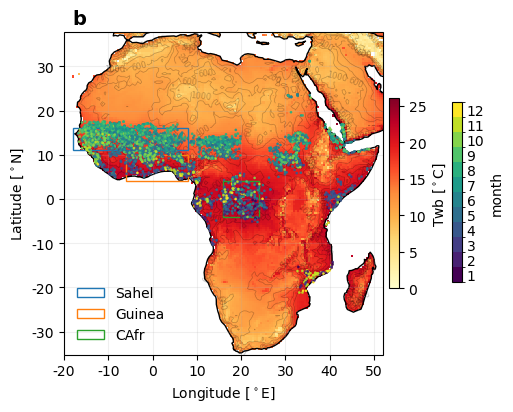

In [28]:
#~ Plot

xtcks_map = np.arange(-20., 50.+1., 1.)[::10]
ytcks_map = np.arange(-30., 30.+10., 10.)
xtlbs_map = [int(xtk) for xtk in xtcks_map]
ytlbs_map = [int(ytk) for ytk in ytcks_map]

colors_ = [list(colors.TABLEAU_COLORS.values())[i] for i in range(len(study_regions_2plot))]

cmap_months = plt.get_cmap(cmap_dates)
bounds_months = np.arange(months[0], months[-1]+2, 1)
norm_months = BoundaryNorm(bounds_months, cmap_months.N)
cbtcks = bounds_months+0.5
cbtcks = cbtcks[:-1]
cblbs = bounds_months[:-1]

cmap = plt.get_cmap('YlOrRd')

fig, ax = plt.subplots(subplot_kw={'projection': proj}, dpi=100)

plt.subplots_adjust(left=0.11, right=0.875, bottom=0.085, top=0.99)

p = ax.pcolormesh(lons_, lats_, clim_, vmin=np.floor(clim.min()), vmax=np.ceil(clim.max()), cmap=cmap)

pt = ax.contour(lons_topo_, lats_topo_, topovals_, levels=[200, 400, 600, 1000, 1600, 2400], linewidths=0.5, alpha=0.25, colors='k')
ax.clabel(pt, pt.levels, inline=True, fontsize=6.)

ax.text(0.025, 1.025, flabel, weight="bold", fontsize=14, transform=ax.transAxes)

cdates = mpl.cm.ScalarMappable(norm=norm_months, cmap=cmap_months)

cax = fig.add_axes([0.885, 0.315, 0.02, 0.45])

cb_dates = fig.colorbar(cdates, cax=cax, orientation='vertical', label='month')
cb_dates.ax.tick_params(size=0)
cb_dates.set_ticks(ticks=cbtcks, labels=cblbs)


# add HHE event locations

ntot = []

for reg in regs:
    if ('Sahel' in reg) or ('Guinea' in reg):
        sw_ = [1., 1.]   # to avoid over-lapping
    else:
        sw_ = sw

    coords = study_regions[reg]
    lat_range_ = coords[0]
    lon_range_ = coords[1]

    dates_hhee = load_composite_dates_hhee(ds, res, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw_, tw, lat_range_, lon_range_, min_hw_size, max_hw_size, meth, cnty)
    months_hhee = [int(d[5:7]) for d in dates_hhee]

    coords_hhee = load_composite_coords_hhee(ds, res, var, y0, y1, months, t_thresh, q_thresh, n_days, window, sw_, tw, lat_range_, lon_range_, min_hw_size, max_hw_size, meth, cnty)
    lats_hhee = [coord[0] for coord in coords_hhee]
    lons_hhee = [coord[1] for coord in coords_hhee]

    ax.scatter(lons_hhee, lats_hhee, s=2.5, c=months_hhee, norm=norm_months, cmap=cmap_months, linewidths=0.25, alpha=0.95, zorder=100)

    ntot.append(len(dates_hhee))

               
# add study regions

for i, reg in enumerate(regs2plot):
    coords = study_regions_2plot[reg]
    lat_range_ = coords[0]
    lon_range_ = coords[1]

    lon_min_ = lon_range_[0] + 4 / 2
    lat_min_ = lat_range_[0] + 4 / 2
    width = lon_range_[1] - lon_range_[0] - 4  # swlon
    height = lat_range_[1] - lat_range_[0] - 4  # swlat

    ax.add_patch(Rectangle((lon_min_, lat_min_), width, height, color=colors_[i], lw=1., fill=False, zorder=10))

handles = [Patch(facecolor='none', edgecolor=color, label=reg) for color, reg in zip(colors_, regs2plot)]

ax.coastlines()

ax.grid(True, alpha=0.2)
ax.set_xticks(xtcks_map)
ax.set_xticklabels(xtlbs_map)
ax.set_xlim(lon_min, lon_max)
ax.set_yticks(ytcks_map)
ax.set_yticklabels(ytlbs_map)
ax.set_xlabel('Longitude [$^\circ$E]')
ax.set_ylabel('Latitude [$^\circ$N]')

ax.legend(handles=handles, loc='lower left', frameon=False)

cb = fig.colorbar(p, ax=ax, extend='neither', orientation='vertical', label='Twb [$^\circ$C]', shrink=0.525, pad=0.0175)

fig.set_size_inches(5., 4.)